# Проект: исследование замены плитки КС SGT5-2000E

## Описание проекта
В данном проекте ставится задача - проверить зависимость вероятности возникновения дефекта от расположения плитки в пламенной трубе и предложить новые алгоритмы замены плитки с целью оптимизации рисков, трудовых затрат, расхода комплектующих на длинной дистанции.\
Следует понимать что данное исследование производиться на основе данных по ГТ-11Б ТЭЦ-21 ПАО "Мосэнерго", для этой турбины и станции есть характерные особенности эксплуатации - отсутствие жидкого топлива, характерный диспетчерский график, особенности работы дожимных компрессоров, состав топлива и т.д.
## Описание конструкции 
Для лучшего понимания проекта следует иметь ввиду особенности конструкции камер сгорания SGT5-2000E:
1. ГТЭ-160 имеет две выносные камеры сгорания
2. Крепление плитки камеры сгорания устроено следующим образом:\
    2.1 Пламенная труба имеет 36 вертикальных рядов плитки, каждый из которых делится на *A1, A2, B, C, D, E, F, G, H, I, K, L* - ряды\
    2.2 Демонтаж любой плитки осуществляется последовательно от замкового *F*-ряда до дефектной плитки\
    2.3 Плитки *A1, A2*-рядов имеют усеченную форму, плитка *F*-ряда имеет свою уникальную форму.
3. Монтаж плитки ведется в обратном порядке - от замененной плитки до плитки *F*-ряда

## План работы
1. [Импорт данных](#import)
2. [Исследование замен плитки](#research) 
3. [Общий вывод](#conlusion)

### 1. Импорт данных <a id='import'></a>

In [1]:
# используемые в работе библиотеки
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Данные по замене плитки для данного исследования были перенесены с формуляров, заполненных вручную. Поэтому этап предобработки данных не актуален для данного исследования. По сути датасет представляет из себя булев массив на развертке камеры в формате csv.\
Замену плитки можно разделить на два этапа:
1. Дефектация. Поиск дефектов подлежащих устранению.
2. Демонтаж/монтаж. Специфика монтажа такова, что для замены n-ой плитки в ряду необходимо снять все n плиток.

Таким образом мы создаем по две карты для каждой камеры за год - карту дефектов и карту монтажа, отражающую путь монтажника.  Сами карты мы записываем в словарь где ключи - названия карт (с указанием года, камеры и этапа). Для упрощения импорт данных был автоматизирован, в функцию так же встроено заполнение нулями пропусков.

In [2]:
# функция пдля импорта данных
def import_map(combasting_chamber, kind_of_map, year):
    map =  pd.read_csv('C:/Users/79153/Desktop/ya_projects/21gt_b/'+
                       str(kind_of_map)+'/21'+
                       str(combasting_chamber)+str(year)+'.csv',
                       sep=';',
                       index_col=0)
    return map.fillna(0)

# параметры импорта данных

years = [2019, 2020, 2021, 2022]           # исследуемые года 
number_chumber = ['LC', 'RC']              # камеры сгорания 
kind = ['defect_map', 'assembling_map']    # карты монтажа и дефектов

# автоматизированный импорт данных в словарь

names = {}                                    
for i in kind:
    for j in number_chumber:
        for k in years:
            names[(str(j)+'_'+str(i)+'_'+str(k))] = import_map(j, i, k)

### 2. Исследование замен плитки   <a id='research'></a> 

Создадим карты обобщающие данные за выбранный период времени

In [3]:
lc_dm_total = 0
lc_am_total = 0
rc_dm_total = 0
rc_am_total = 0

for i in years:
    lc_dm_total += names['LC_defect_map_'+str(i)]
    lc_am_total += names['LC_assembling_map_'+str(i)]
    
    rc_dm_total += names['RC_defect_map_'+str(i)]
    rc_am_total += names['RC_assembling_map_'+str(i)]

Поскольку данный хитмэп выводить придется не один раз напишем функцию для вывода графика

In [4]:
def print_map(map, title):
    fig, axes = plt.subplots(1, 1, figsize=(40,20))
    ax = sns.heatmap(map, cmap="mako",square=True, linewidths=3, linecolor='gray',cbar=False)
    ax.set_title(str( f'{title} {years[0]} - {years[-1]}'))
    ax.set_ylabel('Ряды', fontsize=25)
    ax.set_yticklabels(['A1', 'A2', 'B', 'C', 'D','E','F','G','H','I','K','L'], fontsize=30, rotation = 0)
    ax.set_xticklabels(range(1,37), fontsize=30, rotation = 0)
    ax.title.set_size(40)

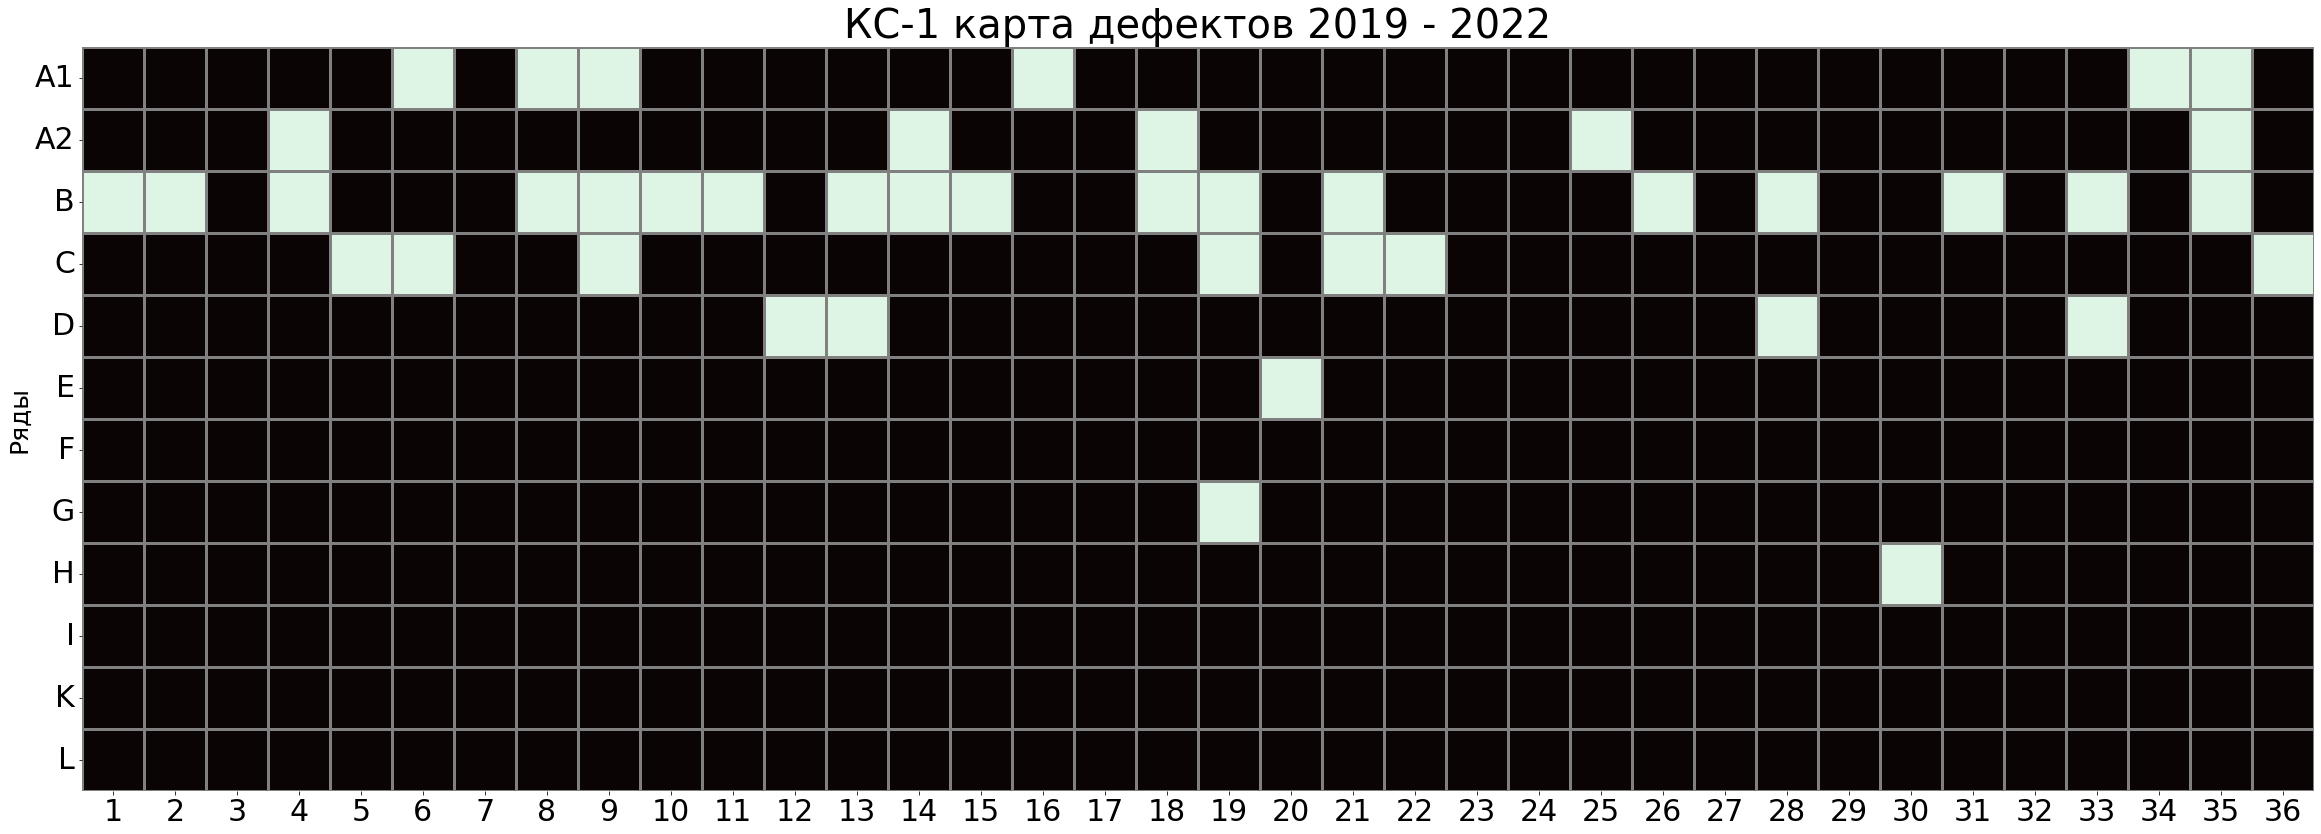

In [5]:
print_map(lc_dm_total, 'КС-1 карта дефектов')

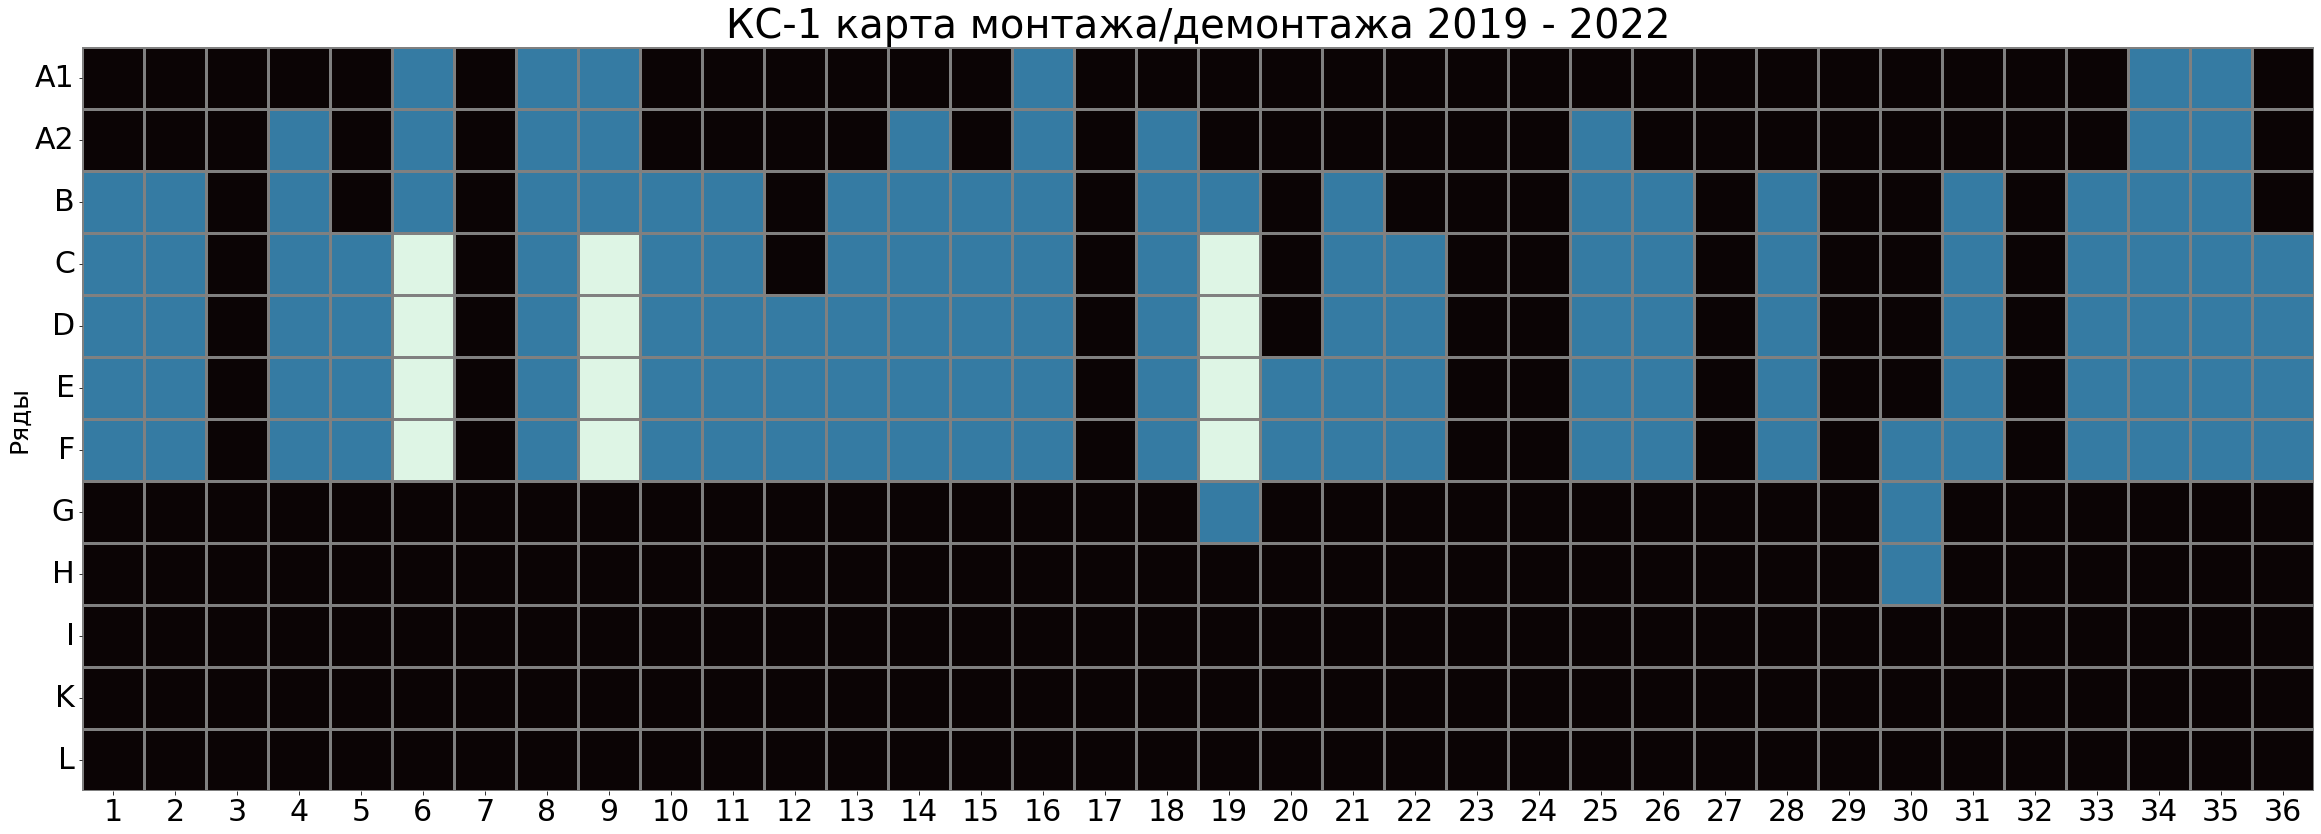

In [6]:
print_map(lc_am_total, 'КС-1 карта монтажа/демонтажа')

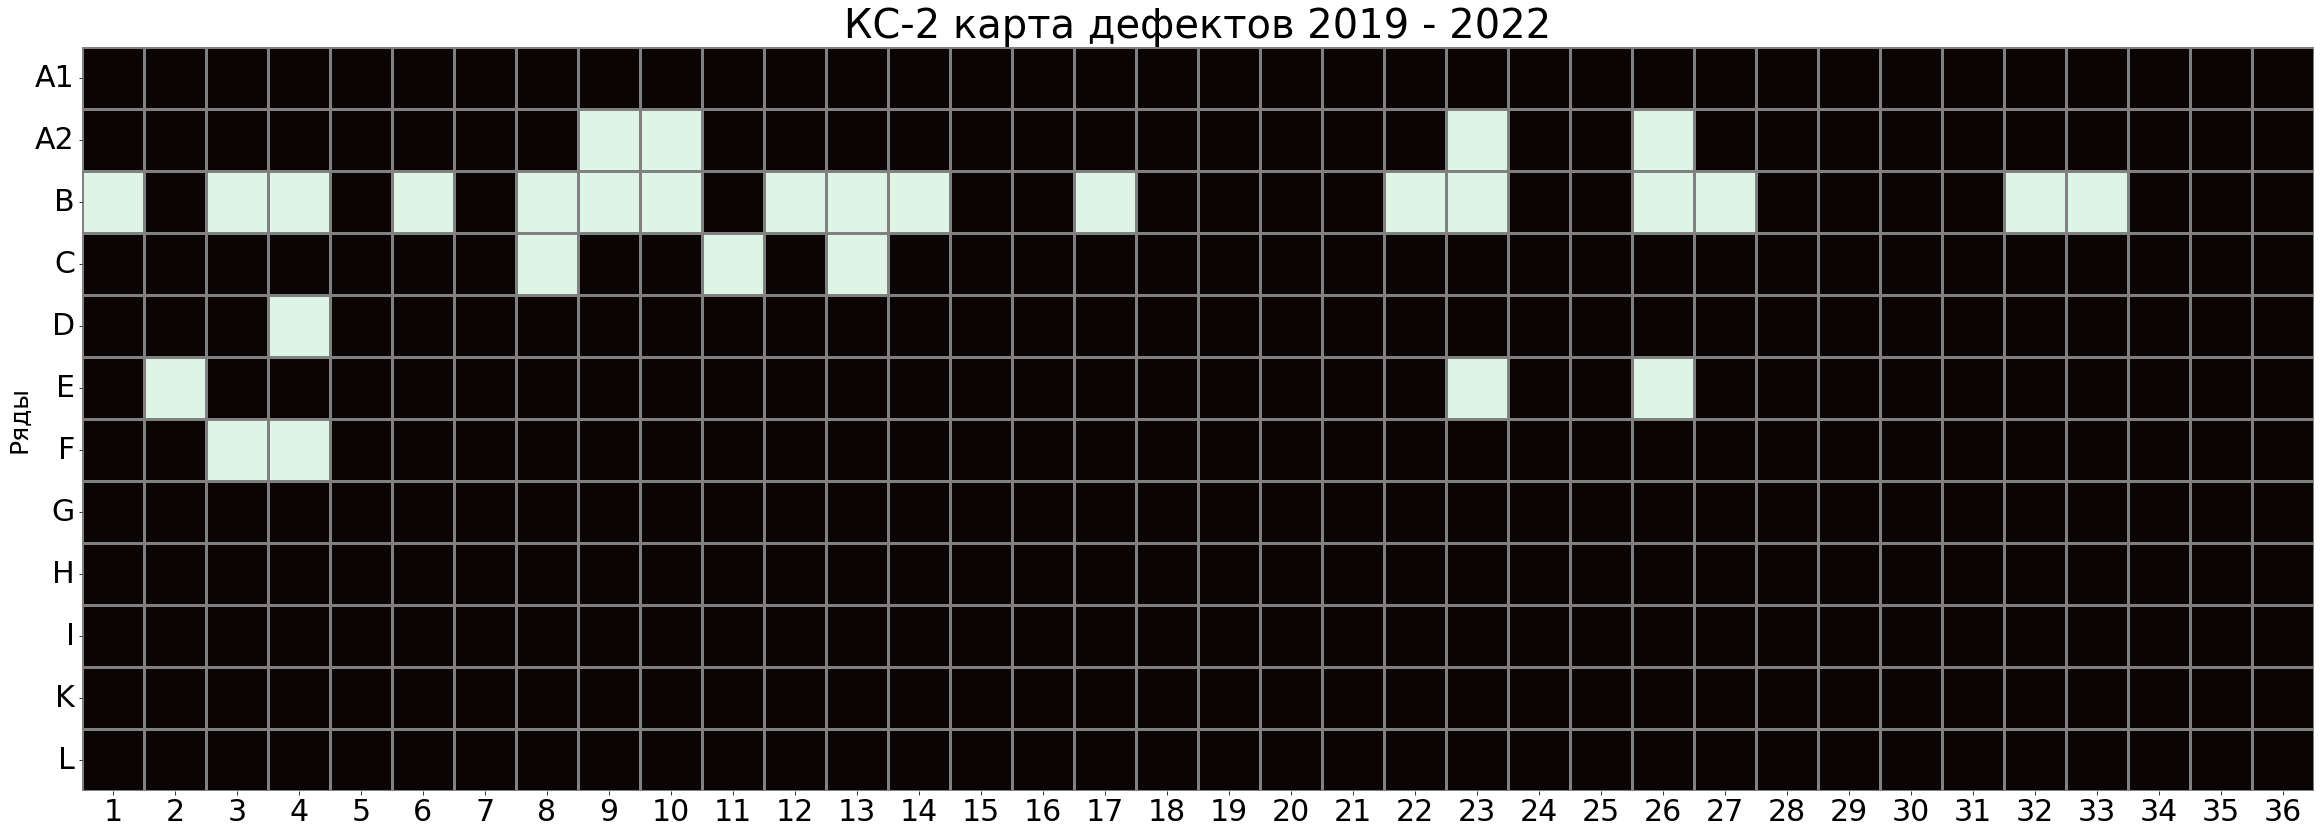

In [7]:
print_map(rc_dm_total, 'КС-2 карта дефектов')

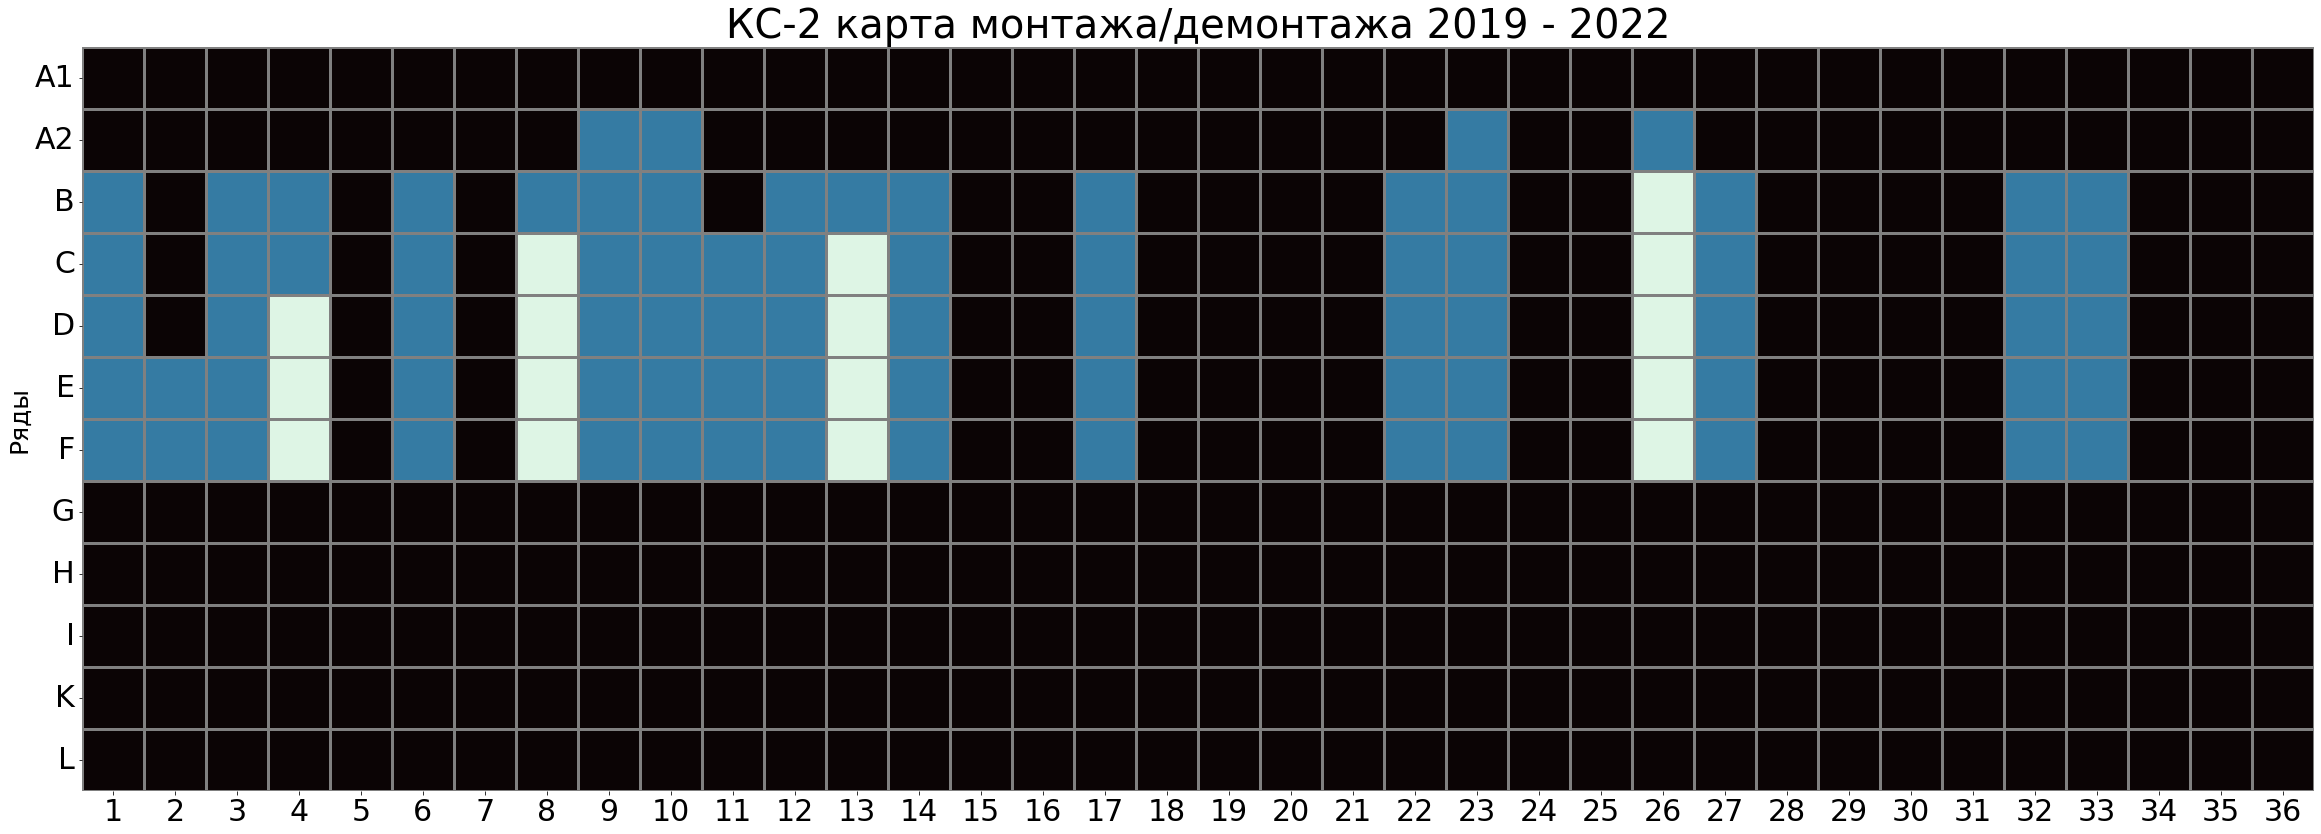

In [8]:
print_map(rc_am_total, 'КС-2 карта монтажа/демонтажа')

Рассчитаем вероятность замены одного и того же столбца плитки как отношение числа столбцов с "множественным" вмешательством к числу всех столбцов с заменами: 

In [9]:
print(f'Процент "повторных" монтажей рядов {round(7/48,4)}')

Процент "повторных" монтажей рядов 0.1458


Транспонируем матрицы для более комфортного обращения

In [10]:
lc_dm_total_t = lc_dm_total.transpose()
lc_am_total_t = lc_am_total.transpose()
rc_dm_total_t = rc_dm_total.transpose()
rc_am_total_t = rc_am_total.transpose()

Напишем функции для подсчета вероятности возникновения дефекта и вероятности демонтажа соответствующего ряда плиток при наличии дефекта в вертикальном ряду

In [11]:
# функция подсчета вероятности дефекта в ряду при наличии дефекта в вертикальном ряду
def p_row_defect(map):
    remove=map.sum().sum()
    p_row = []
    for row in map:
        p_row.append(round(map[row].sum()/remove,4))
    return pd.Series(p_row,index=['A1', 'A2', 'B', 'C', 'D','E','F','G','H','I','K','L'])

# функция для подсчета вероятности демонтажа ряда плиток при наличии дефекта в вертикальном ряду
def p_row_remove(map):
    remove=map.sum().sum()
    p_row = []
    for row in map:
        p_row.append(round(map[row].sum()/remove,4))
    new_map = pd.Series(p_row,index=['A1', 'A2', 'B', 'C', 'D','E','F','G','H','I','K','L'])
    new_map['A2'] = new_map['A2']+new_map['A1']
    new_map['B'] = new_map['A2']+new_map['B']
    new_map['C'] = new_map['C']+new_map['B']
    new_map['D'] = new_map['C']+new_map['D']
    new_map['E'] = new_map['E']+new_map['D']
    new_map['K'] = new_map['L']+new_map['K']
    new_map['I'] = new_map['I']+new_map['K']
    new_map['H'] = new_map['H']+new_map['I']
    new_map['G'] = new_map['H']+new_map['G']  
    new_map['F'] = new_map['E']+new_map['G']+new_map['F']
    
    return pd.Series(new_map,index=['A1', 'A2', 'B', 'C', 'D','E','F','G','H','I','K','L'])


# функция для превентивной замены любого ряда при замене дефектной плитки 
def preventive(map, defect_row, preventive_row):
    for i in range(0,36):
        map[defect_row][i] = 0
        map[preventive_row][i] = 0
    return map


Создание датафрейма где:
- `p_defect` - вероятность дефекта плитки при наличии дефекта в вертикальном ряду
- `p_remove` - вероятность демонтажа плиток при наличии дефекта в вертикальном ряду
- `p_remove_new` - вероятность демонтажа плиток при наличии дефекта в вертикальном ряду при заменных на новые *B* и *C* плитках

In [12]:
df = pd.DataFrame()
df['p_defect'] = p_row_defect(lc_dm_total_t+rc_dm_total_t)
df['p_remove'] = p_row_remove(lc_dm_total_t+rc_dm_total_t)

df['p_remove_new'] = p_row_remove(preventive((lc_dm_total_t+rc_dm_total_t), 'B', 'C'))
df

,p_defect,p_remove,p_remove_new
A1,0.0822,0.0822,0.2143
A2,0.1233,0.2055,0.5357
B,0.4795,0.6850,0.5357
C,0.1370,0.8220,0.5357
D,0.0685,0.8905,0.7143
E,0.0548,0.9453,0.8572
F,0.0274,1.0001,1.0000
G,0.0137,0.0274,0.0714
H,0.0137,0.0137,0.0357
I,0.0000,0.0000,0.0000


Отрисуем график вероятности дефекта плитки при наличии дефекта в вертикальном ряду. Так же посчитаем и добавим на график  средне арифметическую вероятность дефекта плитки для определения группы риска - плитки вероятность дефекта которых ниже данной планки работают в менее тяжелых условиях чем те, у которых вероятность дефекта выше этой планки.\
Наиболее корректно использовать среднеарифметическое значение, так как оно отразит распредение вероятностей по рядам, в отличии от константы. Данный порог поможет нам определить какие плитки можно заменить превентивно для исключения рисков возникновения дефектов при замене и уменьшении сроков данной операции.

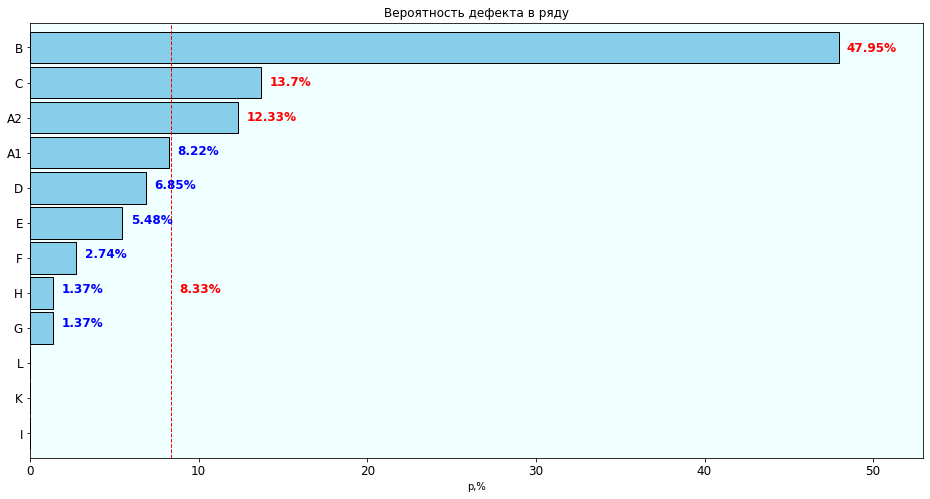

In [13]:
def percent_bar(df):
    percent_df = (df*100).round(2)
    threshold = percent_df.mean()
    fig = plt.figure()
    fig.patch.set_alpha(0.04)
    ax = percent_df.plot(kind='barh', figsize=(16, 8), title='Вероятность дефекта в ряду', 
                               color='skyblue', legend=False, fontsize=12, width=0.9,ec='black')
    plt.xlim([0, percent_df.max()+5])
    ax.set_xlabel('p,%')
    dict_percent = dict(percent_df)
    i = 0
    for k in dict_percent:
        color = 'blue'
        if dict_percent[k] > 0:
            if dict_percent[k] > threshold:
                color = 'red'
            ax.text(dict_percent[k]+0.5, i + 0.1, str(dict_percent[k])+'%', color=color, 
                    fontweight='bold', fontsize='large')
        i += 0.98
    plt.axvline(x=threshold,linewidth=1, color='r', linestyle='--')
    ax.text(threshold+0.5, 4, '{0:.2%}'.format(threshold/100), color='r', fontweight='bold', fontsize='large')
    ax.patch.set_facecolor('#F0FFFF')
    return ax, threshold

plot, threshold = percent_bar(df['p_defect'].sort_values())

Построим графики вероятности демонтажа плиток в ряду при исходной вероятности и при превентивной замене *C* плиток

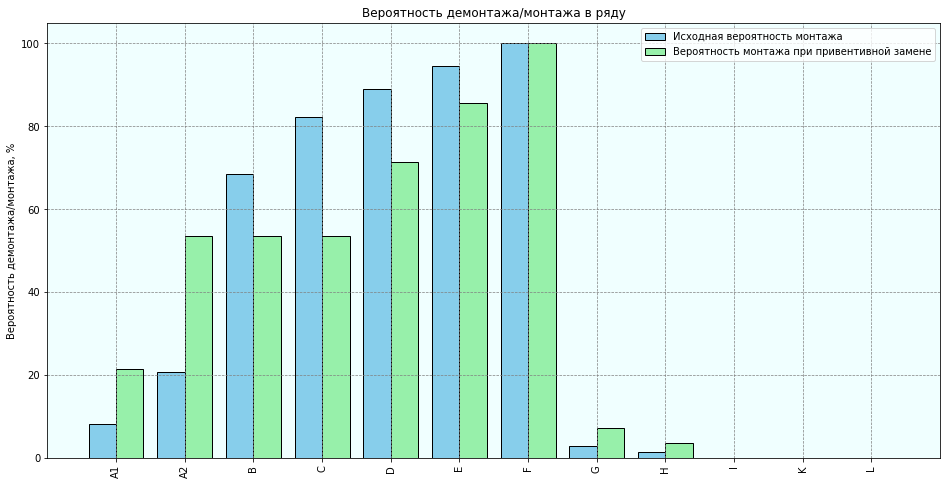

In [14]:
ax = plt.gca()

plot1 = df['p_remove']*100
plot1.plot(kind='bar', figsize=(12,8), ec='black', ax=ax, width=0.4, color='skyblue', position=1)

plot2 = df['p_remove_new']*100
plot2.plot(kind='bar', figsize=(16,8), ec='black', ax=ax, width=0.4, color='#97F0AA', position=0)
ax.legend(['Исходная вероятность монтажа', 'Вероятность монтажа при привентивной замене'])
ax.set_title("Вероятность демонтажа/монтажа в ряду")
ax.set_ylabel("Вероятность демонтажа/монтажа, %")
plt.grid(color = 'gray',    
        linewidth = 0.7,  
        linestyle = '--')
plt.xlim([-1, 12])
ax.patch.set_facecolor('#F0FFFF')
plt.show()

### 3. Общий вывод <a id='conlusion'></a>
Таким образом можно сделать вывод, что наиболее часто заменяемые плитки - B-ряд, но при этом для их замены необходимо демонтировать предшествующие C,D,E,F - что сопряжено с вероятностью:

1. Облома держателей
2. Дефекта шлица винта замкового крепления F-ряда
3. Дефекта резьбы наварной гайки пламенной трубы
4. Возникновение монтажного дефекта плитки C,D,E,F рядов
5. Понесение лишних трудовых затрат

Для минимизации рисков и снижения трудовых затрат предлается при замене плитки пользоваться следующим алгоритмом:
1. При дефекте плитки ниже F заменять дефектную плитку на б/у плитку верхних рядов (если так же есть дефекты выше F) с целью установки новой плитки на места с более сложными эксплуатуационными условиями.
2. При наличии нескольких дефектов в одном вертикальном ряде новые плитки ставить в более высокое положение, устанавливая б/у плитки в ряды с менее тяжелыми эксплуатуационными условиями.
3. При дефекте плитки выше B заменять на новые так же A2, B и С.